In [102]:
import pandas as pd
import numpy as np
from datetime import date
import statsmodels.api as sm
import seaborn as sns

today=str(date.today())

In [143]:
# Data paths
candpath = '/gpfs/milgram/pi/gee_dylan/candlab'
data = candpath + '/analyses/shapes/dwi/data'

# Import subjects
subs = ri_sublist = pd.read_csv(data + '/../subjectlist_preDiss_motion0.75_n116_2021-03-23.csv', names = ['index', 'Subject'], header = 0)
subs['Subject'] = 'sub-' + subs['Subject']

#DTI Column Names
colnames_dti = ['AF_left', 'AF_right', 'ATR_left', 'ATR_right', 'CC_1', 'CC_2', 'CC_3',
       'CC_4', 'CC_5', 'CC_6', 'CC_7', 'CG_left', 'CG_right', 'CST_left',
       'CST_right', 'FPT_left', 'FPT_right', 'ICP_left', 'ICP_right',
       'IFO_left', 'IFO_right', 'ILF_left', 'ILF_right', 'MCP', 'OR_left',
       'OR_right', 'POPT_left', 'POPT_right', 'SCP_left', 'SCP_right',
       'SLF_I_left', 'SLF_I_right', 'SLF_II_left', 'SLF_II_right',
       'SLF_III_left', 'SLF_III_right', 'STR_left', 'STR_right', 'UF_left',
       'UF_right', 'T_PREM_left', 'T_PREM_right', 'T_PAR_left', 'T_PAR_right',
       'T_OCC_left', 'T_OCC_right', 'ST_FO_left', 'ST_FO_right',
       'ST_PREM_left', 'ST_PREM_right']

### Data Cleaning

In [147]:
# Import demographic data
demo_raw = pd.read_csv(data + '/Analysis/Behavioral/Demographic_Info.csv', 
                   header = 0).rename(columns = {'subj_id':'Subject', 'branch_a_sex':'sex'})
demo = demo_raw[['Subject', 'sex', 'asr_age']].set_index('Subject')

diag = pd.read_csv(data + '/Analysis/Behavioral/DiagnosticStatus.csv', 
                   header = 0).rename(columns = {'record_id':'Subject', 'cc_group':'diagnostic_group'})
diag_only = diag[['Subject', 'diagnostic_group']].set_index('Subject')

demo_data = pd.concat([demo, diag_only], axis=1).reset_index()
demo_data['Subject'] = 'sub-' + demo_data['Subject']

#Import RI data (Wide)
ri1 = pd.read_csv(data + '/Analysis/Behavioral/Cleaned_WIDE_threat_endorsements_2021-03-26.csv', 
                  header = 0).rename(columns = {'Unnamed: 0':'Subject'}).drop([0,1], axis=0)
ri1.columns = 'threat_' + ri1.columns
ri1 = ri1.rename(columns = {'threat_Subject':'Subject'}).set_index('Subject')

ri2 = pd.read_csv(data + '/Analysis/Behavioral/Cleaned_WIDE_dep_endorsements_2021-03-26.csv', 
                  header = 0).rename(columns = {'Unnamed: 0':'Subject'}).drop([0,1], axis=0)
ri2.columns = 'dep_' + ri2.columns
ri2 = ri2.rename(columns = {'dep_Subject':'Subject'}).set_index('Subject')

ri3 = pd.read_csv(data + '/Analysis/Behavioral/Cleaned_WIDE_any_endorsements_2021-03-26.csv', 
                  header = 0).rename(columns = {'Unnamed: 0':'Subject'}).drop([0,1], axis=0)
ri3.columns = 'all_' + ri3.columns
ri3 = ri3.rename(columns = {'all_Subject':'Subject'}).set_index('Subject')

ri_data = pd.concat([ri1, ri2, ri3], axis=1).reset_index()
ri_data['Subject'] = 'sub-' + ri_data['Subject']

In [173]:
#Import RI data (long)
ri4 = pd.read_csv(data + '/Analysis/Behavioral/Cleaned_threat_endorsements_2021-03-26.csv',
                  header = 0).rename(columns = {'ucla_a_id':'Subject'})
ri4.columns = 'threat_' + ri4.columns
ri4 = ri4.rename(columns = {'threat_Subject':'Subject'})
ri4['Subject'] = 'sub-' + ri4['Subject']

ri5 = pd.read_csv(data + '/Analysis/Behavioral/Cleaned_dep_endorsements_2021-03-26.csv',
                  header = 0).rename(columns = {'ucla_a_id':'Subject'})
ri5.columns = 'dep_' + ri5.columns
ri5 = ri5.rename(columns = {'dep_Subject':'Subject'})
ri5['Subject'] = 'sub-' + ri5['Subject']

ri6 = pd.read_csv(data + '/Analysis/Behavioral/Cleaned_all_endorsements_2021-03-26.csv',
                  header = 0).rename(columns = {'ucla_a_id':'Subject'})
ri6.columns = 'all_' + ri6.columns
ri6 = ri6.rename(columns = {'all_Subject':'Subject'})
ri6['Subject'] = 'sub-' + ri6['Subject']

In [177]:
#Merge data together
m1 = pd.merge(subs['Subject'], demo_data, how = 'left', on='Subject').dropna(how = 'any', axis=0)
m2 = pd.merge(m1, ri_data, how = 'left', on='Subject')

bx_df = m2
bx_df.shape

long_thr_df = pd.merge(m1, ri4, how = 'inner', on = 'Subject')
long_dep_df = pd.merge(m1, ri5, how = 'inner', on = 'Subject')
long_all_df = pd.merge(m1, ri6, how = 'inner', on = 'Subject')

In [12]:
def compute_tract_means(sub_df):
    output = np.ones((len(sub_df), 50), dtype='object')
    for i in range(0, len(sub_df)):
        sub = sub_df['Subject'][i]
        try:
            rawdata = pd.read_csv(data + '/tract_output/{}/Tractometry_{}.csv'.format(sub, sub), header = 0, sep = ';')
            column_names = rawdata.columns
            means = rawdata.mean(axis=0)
            output[i,:] = means
        except:
            print("No output for {}".format(sub))
            output[i,:] = np.nan
    output_df = pd.concat([sub_df['Subject'], pd.DataFrame(output, columns = column_names)], axis=1)
    return output_df

In [199]:
def extract_uf(sub_df):
    l_output = np.ones((len(sub_df), 98), dtype='object')
    r_output = np.ones((len(sub_df), 98), dtype='object')
    for i in range(0, len(sub_df)):
        sub = sub_df['Subject'][i]
        try:
            rawdata = pd.read_csv(data + '/tract_output/{}/Tractometry_{}.csv'.format(sub, sub), header = 0, sep = ';')
            luf_data = rawdata['UF_left']
            ruf_data = rawdata['UF_right']
            l_output[i, :] = luf_data
            r_output[i, :] = ruf_data
        except:
            print("No output for {}".format(sub))
            output[i,:] = np.nan
    l_output_df = pd.concat([sub_df['Subject'], pd.DataFrame(l_output)], axis=1)
    r_output_df = pd.concat([sub_df['Subject'], pd.DataFrame(r_output)], axis=1)
    return l_output_df, r_output_df

luf_df, ruf_df = extract_uf(bx_df)

In [99]:
def regress_covariates(dti_df, behav_df):
    regressed_output = np.ones((len(dti_df), len(dti_df.columns)-1))
    
    regressors = behav_df[['sex', 'asr_age', 'diagnostic_group']]
    regressors['sex'] = regressors['sex'].astype('category')
    regressors['asr_age'] = regressors['asr_age'].astype(float)
    regressors['diagnostic_group'] = regressors['diagnostic_group'].astype('category')
    regressors = sm.add_constant(regressors) #Add intercept for OLS regression per https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html
    for i in range(0, len(dti_df.columns)-1):
        #Set variables and ensure dtype
        sub = behav_df['Subject'][i]
        dti_col = dti_df.drop('Subject', axis=1).to_numpy()[:,i].astype(float)
        model = sm.OLS(endog = dti_col, exog=regressors)
        result = model.fit()
        regressed_output[:,i] = result.resid
    
    return regressed_output

In [178]:
#Compute tract means
mean_df = compute_tract_means(bx_df).dropna(axis=0) #Input is bxdf so that subjects will be in same order

#Regress age, sex, and diagnostic group from dti
resid_mat = regress_covariates(mean_df, bx_df)
resid_df = pd.DataFrame(pd.concat([mean_df['Subject'], pd.DataFrame(resid_mat, columns = colnames_dti)], axis=1))

#Merge with long dfs
long_thr_df_dwi = pd.merge(long_thr_df, resid_df, on='Subject', how = 'inner')
long_dep_df_dwi = pd.merge(long_dep_df, resid_df, on='Subject', how = 'inner')
long_all_df_dwi = pd.merge(long_all_df, resid_df, on='Subject', how = 'inner')

#Extract specific tracts
left_uf = resid_mat[:, 38]
right_uf = resid_mat[:, 39]

# #Prepare bx data for CCA
bx_mat = bx_df.drop(['all_Summed_All', 'diagnostic_group', 'asr_age', 'sex', 'Subject'], 
                    axis=1).replace(np.nan, 0).to_numpy()
bx_all = bx_df[['all_Summed_All']].replace(np.nan, 0).to_numpy().reshape(len(bx_df), )

subids = mean_df['Subject']

/gpfs/milgram/project/gee_dylan/lms233/conda_envs/mybrainiak/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/gpfs/milgram/project/gee_dylan/lms233/conda_envs/mybrainiak/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/gpfs/milgram/project/gee_dylan/lms233/conda_envs/mybrainiak/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

### Visualization

In [150]:
long_df = pd.melt(resid_df, id_vars = 'Subject', var_name = 'Tract', value_name = 'Value')
plotdf_long = pd.merge(long_df, bx_df)
plotdf_wide = pd.merge(resid_df, bx_df)

# Clean outliers
cleaned = plotdf_wide[plotdf_wide['UF_left'] > -0.3]
cleaned = cleaned[cleaned['threat_Summed_All'] < 700]

In [151]:
resid_df.columns

Index(['Subject', 'AF_left', 'AF_right', 'ATR_left', 'ATR_right', 'CC_1',
       'CC_2', 'CC_3', 'CC_4', 'CC_5', 'CC_6', 'CC_7', 'CG_left', 'CG_right',
       'CST_left', 'CST_right', 'FPT_left', 'FPT_right', 'ICP_left',
       'ICP_right', 'IFO_left', 'IFO_right', 'ILF_left', 'ILF_right', 'MCP',
       'OR_left', 'OR_right', 'POPT_left', 'POPT_right', 'SCP_left',
       'SCP_right', 'SLF_I_left', 'SLF_I_right', 'SLF_II_left', 'SLF_II_right',
       'SLF_III_left', 'SLF_III_right', 'STR_left', 'STR_right', 'UF_left',
       'UF_right', 'T_PREM_left', 'T_PREM_right', 'T_PAR_left', 'T_PAR_right',
       'T_OCC_left', 'T_OCC_right', 'ST_FO_left', 'ST_FO_right',
       'ST_PREM_left', 'ST_PREM_right'],
      dtype='object')

<AxesSubplot:xlabel='dep_Summed_Dep', ylabel='UF_left'>

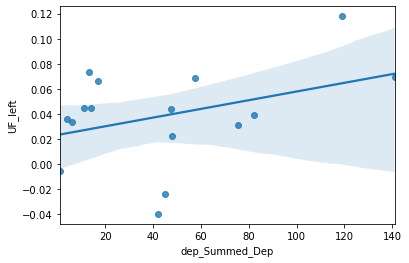

In [153]:
#Boxplots
sns.regplot(x=cleaned['dep_Summed_Dep'], y = cleaned['UF_left'])

<AxesSubplot:xlabel='sex', ylabel='UF_left'>

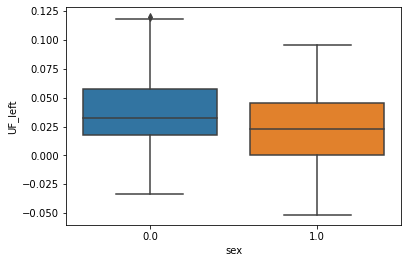

In [138]:
sns.boxplot(x=cleaned['sex'], y = cleaned['UF_left'])

### OLS/LME Analysis

In [186]:
yvar = 'UF_left'
# long_thr_df_dwi

In [196]:
lme_mod = sm.MixedLM.from_formula("{} ~ threat_Summed_Threat * sex + asr_age + sex + diagnostic_group".format(yvar), 
                                 re_formula="1", 
                groups="Subject", data=plotdf_wide.replace(np.nan, 0))
results = lme_mod.fit()
print(results.summary())

               Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     UF_left
No. Observations:       93          Method:                 REML   
No. Groups:             93          Scale:                  0.0086 
Min. group size:        1           Log-Likelihood:         31.5703
Max. group size:        1           Converged:              Yes    
Mean group size:        1.0                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                -0.012    0.075 -0.158 0.875 -0.158  0.135
threat_Summed_Threat      0.000    0.000  0.420 0.674 -0.001  0.001
sex                       0.006    0.032  0.172 0.864 -0.058  0.069
threat_Summed_Threat:sex -0.000    0.000 -0.394 0.694 -0.001  0.001
asr_age                   0.000    0.002  0.174 0.862 -0.003  0

/gpfs/milgram/project/gee_dylan/lms233/conda_envs/mybrainiak/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/gpfs/milgram/project/gee_dylan/lms233/conda_envs/mybrainiak/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [87]:
regressors = bx_df[['asr_age', 'sex', 'diagnostic_group', 'all_Summed_All']].replace(np.nan, 0)
model = sm.OLS(endog = right_uf, exog=regressors)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.044
Method:                 Least Squares   F-statistic:                            0.03019
Date:                Fri, 26 Mar 2021   Prob (F-statistic):                       0.998
Time:                        20:16:44   Log-Likelihood:                          60.079
No. Observations:                  93   AIC:                                     -112.2
Df Residuals:                      89   BIC:                                     -102.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [ ]:
regressors = plotdf_wide[['Subject', 'asr_age', 'sex', 'diagnostic_group']].replace(np.nan, 0)
reg_all = pd.merge(regressors, luf_df, on = 'Subject').drop('Subject', axis=1).to_numpy().astype(float)
yvar = plotdf_wide['all_Summed_All'].to_numpy().astype(float)

regression = Ridge(normalize = True, alpha=1.0)
regfit = regression.fit(reg_all, yvar)
regfit

### Ridge Regression Analysis

In [77]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr

def perform_cv(subids, neural_data, bx_data):
    numbers1 = pd.Series(range(0, len(neural_data))).to_numpy()
    reg_corr = []
    reg_p = []
    r2 = []
    for i in range(0, 50):
        X_train, X_test, y_train, y_test = train_test_split(neural_data, bx_data, test_size=0.33, random_state=i)

        # Train the model 
        regression = Ridge(normalize = True, alpha=1.0)
        regfit = regression.fit(X_train, y_train)

        # Test the model
        score = regfit.predict(X_test)
        corr, p = spearmanr(score, y_test)
        reg_corr.append(corr)
        reg_p.append(p)
        print('Correlation between train and test: {}'.format(corr))
        print('P-value: {}'.format(p))
        score = regfit.score(X_test, y_test)
        r2.append(score)
    return reg_corr, reg_p, r2

In [79]:
corr, pvals, r2_list = perform_cv(subids, l_, l_uf_df)

Correlation between train and test: -0.13470397652008118
P-value: 0.46999802366069476
Correlation between train and test: -0.38728576730731273
P-value: 0.03135766126120925
Correlation between train and test: 0.11111290174962021
P-value: 0.5517933823786652
Correlation between train and test: -0.14274358180973107
P-value: 0.4436537859431303
Correlation between train and test: 0.10178590634727984
P-value: 0.585857059914406
Correlation between train and test: 0.031765500078723
P-value: 0.8652953590380698
Correlation between train and test: 0.08434848016029564
P-value: 0.6518895647229738
Correlation between train and test: -0.3424746554556003
P-value: 0.05930275123488388
Correlation between train and test: -0.1387970258216814
P-value: 0.4564848114587098
Correlation between train and test: -0.303288044104304
P-value: 0.0972022762311742
Correlation between train and test: -0.4795969382663557
P-value: 0.006331768962323641
Correlation between train and test: -0.05645730445064192
P-value: 0.7629

### CCA Analysis

In [231]:
from sklearn.cross_decomposition import CCA

In [262]:
pd.Series(colnames_dti)

0           AF_left
1          AF_right
2          ATR_left
3         ATR_right
4              CC_1
5              CC_2
6              CC_3
7              CC_4
8              CC_5
9              CC_6
10             CC_7
11          CG_left
12         CG_right
13         CST_left
14        CST_right
15         FPT_left
16        FPT_right
17         ICP_left
18        ICP_right
19         IFO_left
20        IFO_right
21         ILF_left
22        ILF_right
23              MCP
24          OR_left
25         OR_right
26        POPT_left
27       POPT_right
28         SCP_left
29        SCP_right
30       SLF_I_left
31      SLF_I_right
32      SLF_II_left
33     SLF_II_right
34     SLF_III_left
35    SLF_III_right
36         STR_left
37        STR_right
38          UF_left
39         UF_right
40      T_PREM_left
41     T_PREM_right
42       T_PAR_left
43      T_PAR_right
44       T_OCC_left
45      T_OCC_right
46       ST_FO_left
47      ST_FO_right
48     ST_PREM_left
49    ST_PREM_right


In [252]:
cca = CCA(n_components=6, scale = True, copy = True)
cca.fit(X = bx_mat, Y = resid_df)
# CCA(n_components=1)
# X_c, Y_c = cca.transform(X, Y)

CCA(n_components=6)

In [254]:
xtest = np.where(cca.y_weights_ < 0.1, 0, cca.y_weights_ )
pd.DataFrame(xtest)

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.170856,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.359382,0.000000
4,0.000000,0.103717,0.000000,0.230141,0.113409,0.000000
5,0.266683,0.000000,0.295407,0.000000,0.000000,0.000000
6,0.000000,0.240805,0.000000,0.000000,0.000000,0.000000
7,0.109448,0.000000,0.000000,0.226080,0.000000,0.136623
8,0.000000,0.000000,0.000000,0.000000,0.130642,0.000000
9,0.000000,0.308734,0.105532,0.000000,0.000000,0.176750
